# MNIST Dataset (Classification)
**Dataset provided by Sciki-Learn.**

**70,000 small images of digits handwritten by highs school students and US Census Bureau employees.**

**Each image is labeled with the digit it represents.**


In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

In [2]:
# Import Dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

**Get the "data" and "target".**

In [3]:
# Split into X/y
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

**There are 70,000 images, and each image has 784 features, each image is 28x28 pixels (each feature represents one pixels intensity from 0(white) to 255(black).**)

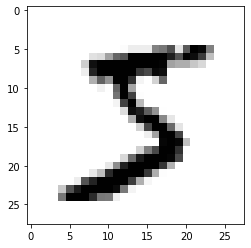

'5'

In [4]:
# Look at one digit of the dataset
# Grabing the instance's feature vector
some_digit = X[0]

# Reshape it to 28x28
some_digit_image = some_digit.reshape(28, 28)

# Disply using Matplotlib's "imshow()" function
plt.imshow(some_digit_image, cmap="binary")
plt.show();

# Check the label of "X[0]"
y[0]

**The label is a string. ML algorithms expect number.**

In [5]:
# Cast "y" to integer
y = y.astype(np.uint8)
y[0]

5

## Plot some the first 100 digits

In [72]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap="binary")   # add 'intepolation="nearest"' if not working
    plt.axis("off")

In [7]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

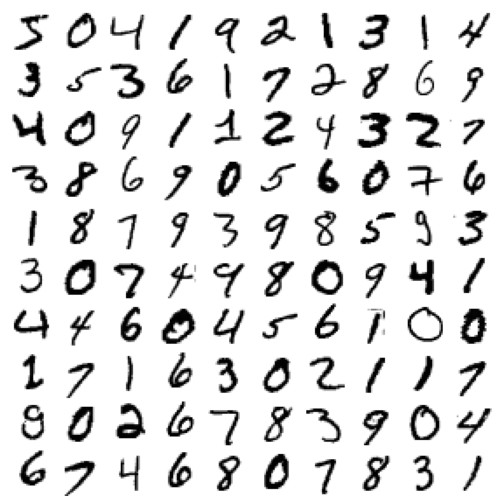

In [8]:
plt.figure(figsize=(9, 9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show();

## Split the data
**MNIST data set is already split into training set (first 60,000 images) and test set (last 10,000 images).**

**The training set is already shuffled, which guarantiees that all cross-validation folds will be similar.**

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
**Simplify the problem for now and only try to indentify on digit ---> 5.**

**This is an example of a <font color='green'>binary classifier</font>, capable of distinguishing between two classes 5 and not 5.**

In [10]:
# Create a target vector for this classification task
y_train_5 = (y_train == 5)  # True for all 5's, False for all the other digits
y_test_5 = (y_test == 5)

### SGDClassifier
**A good place to start is with a <font color='green'>Stochastic Gradient Descent (SGD)</font> classifier.**

This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because **(SGD)** deals with training instances independently, one at a time which also make **(SGD)** well suited for online learning.

**(SGD)** relies on randomness during training. To reproduce results set <font color='red'>random_state</font> parameter.

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
# Check if the model can guess the digit instatiated "some_digit" from above
sgd_clf.predict([some_digit])

array([ True])

## Performance Measure
**<font color='blue'>Evaluating a classifier is often significantly trickier than evaluating a regressor.</font>**

### Measuring Accuracy Using Cross-Validation

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

**The above accuracy is above 95%.**

**Before moving on, look at a classifier that just classifies every single image in the "not-5" class.**

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

**It has over 90% accuracy.**
This is because only about 10% of the images are <font color='red'>5's</font>, so if you always guess that an image is <font color='red'>not a 5</font>, you will be right about 90% of the time.

**<font color='red'>This demonstrates why accuracy is generally not the prefered performance measure for classifiers, especially when you are dealing with <font color='green'>skewed datasets</font> (when some classes are much more frequent than others).</font>**

### Confusion Matrix
**<font color='navy'>A much better way to evaluate the performance of a classifier is to look at the <font color='salmon'>confusion matrix</font>.</font>**

The geneal idea is to count the number of times instances of class <font color='salmon'>A</font> are classified as class <font color='salmon'>B</font>.

To compute the confusion matrix, you first need to have a set of predictions so that the can be computed to the actual target.

**Use the <font color='red'>cross_val_predict()</font>.**

Just like <font color='red'>cross_val_score()</font> function, <font color='red'>cross_val_predict()</font> performs K-fold cross-validations, but instead of returning the evaluation scores it returnes the predictions made on each test fold.

**<font color='navy'>This means that you get a clean prediction for each instance in the training set</font> ("clean" meaning that the prediction is made by a model that never saw the data during training<font color='navy'>.</font>**

In [15]:
from sklearn.model_selection import cross_val_predict
np.random.seed(42)

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
np.random.seed(42)

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

* **<font color='salmon'>Each row in a confusion matrix represents an <font color='blue'>actual class</font>.</font>**
* **<font color='salmon'>Each column represents a <font color='blue'>predicted class</font>.</font>**

The fist row considers non-5 images (the <font color='blue'>negative class</font>):
* 53,892 were correctly classified sd non-5s: **<font color='plasma'>true negatives (TN)</font>**.
* 687 were wrongly classified as 5s: **<font color='plasma'>false positive (FP)</font>**.

The secound row considers the images of 5s (<font color='blue'>positive class</font>):
* 1,891 were wrongly clssified as non-55s: **<font color='plasma'>false negatives (FN)</font>**.
* 3,530 were correctly classified as 5s: **<font color='plasma'>true positives (TP)</font>**.

**A perfect classifier would have only true positives and true negatives:**
>[54579, 0]

>[0, 54579]

### Precision, Recall and F1 Score
The confusoin matrix gives a lot of information , but sometimes you may prefer a more concise(brief but comprehensive
) metric.

**One to look at is the accuracy of the positive predictions: <font color='blue'>precision</font>**
* Equation: **<font color='salmon'>TP / (TP + FP)</font>**

**Precision is typically used along with <font color='blue'>recall</font> also called <font color='blue'>sensitivity</font> or <font color='blue'>true positive rate (TPR)</font>: the ratio of possitive instances that are correctly predicted.**
* Equation: **<font color='salmon'>TP / (TP + FN)</font>**

For example:
* If you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (<font color='blue'>low recall</font>) but keeps only safe ones (<font color='blue'>high precision</font>), rather than a classifier that has a (<font color='blue'>much higher recall</font>) but lets a few really bad videos show up in your product (in such case, you may even want to add a human pipeline to check the classifier's video selection).
* If you train a classifier to detect shoplifters in surveillance images: it is pribably fine if your classifier has <font color='blue'>only 30% precision</font> as long as it has <font color='blue'>99% recall</font> (the sequrity guards will get a few false alarms, but almost all shoplifters will get caught).

**<font color='salmon'>Increasing precision reduces recall, and vice versa (precision/recall trade-off).</font>**

In [17]:
from sklearn.metrics import precision_score, recall_score

# 3,530 / (3,530 + 687)
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
# 3,530 / (3,530 + 1,891)
recall_score(y_train_5, y_train_pred)

0.6511713705958311

* **When it claims an image represents a 5 we get 83.7% accuracy.**
* **It only detects 65.1% of the 5s.**

#### F1 - score
It is ofter convenient to combine <font color='blue'>precision</font> and <font color='blue'>recall</font> into a single metric called **<font color='blue'>F1 score</font>**. In particular if you need a simple way to comparre two classifiers.

The <font color='blue'>F1 score</font> is the **<font color='salmon'>harmonic mean</font>** of <font color='blue'>precision</font> and <font color='blue'>recall</font>.

**The <font color='salmon'>regular mean</font> treats all values equally, the <font color='salmon'>harmonic mean</font> gives much more weight to low values:**
* **The classifier will only get high <font color='blue'>F1 score</font> if both the recall and precision are high.**
* **It favores classifiers that have similar precision and recall.**

In [19]:
from sklearn.metrics import f1_score
np.random.seed(42)

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Trade-off
**To understand this trade-off look at how the <font color='blue'>SGDClassifier</font> makes its classification decisions**

It computes a score based on a <font color='blue'>decision function</font>. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

**Lowering the threshold increases recall and reduces precision.**

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions.

**Instead of calling the classifier's <font color='blue'>predict()</font> method, you can call <font color='blue'>decision_function()</font> method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores.**

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred =  (y_scores > threshold)
y_some_digit_pred

array([ True])

Above the SGDClassifier uses a threshold equal to 0, so the code returns the same result as <font color='blue'>predict()</font> method.

Raise the threshold.

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

**Rasing threshold decreases <font color='blue'>recall</font>.**

The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is incresased to 8000.

### How do you decide witch threshold to use?

**1. Use the <font color='blue'>cross_val_predict()</font> function to get the score of all instances in the training set, but this time scpecify the you want to return <font color='salmon'>decision score</font> instead of predictions.**


In [23]:
np.random.seed(42)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")    # set the method to return decision score
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

**2. Use the <font color='blue'>precision_recall_curve()</font> function to compute precision and recall for all possible thresholds.**

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
print(precisions, recalls, thresholds)

[0.09040123 0.09038606 0.09038757 ... 1.         1.         1.        ] [1.00000000e+00 9.99815532e-01 9.99815532e-01 ... 3.68935621e-04
 1.84467810e-04 0.00000000e+00] [-106527.45300471 -105763.22240074 -105406.2965229  ...   38871.26391927
   42216.05562787   49441.43765905]


**3. Plot precision and recall as functions of the threshold value.**

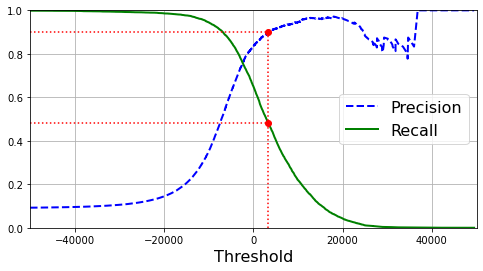

Precision may sometimes go down when you rase the threshold, although in general it will go up.
Recall can only go down when the threshold is increased, whitch explains the smooth curve.


In [25]:
def plot_precision_reacall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)  # precision line
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)   # recall line
    plt.legend(loc="center right", fontsize=16)  # legend
    plt.xlabel("Threshold", fontsize=16)  # x label
    plt.grid(True)   # background of the plot
    plt.axis([-50000, 50000, 0, 1])   # y/x ticks value range
    
# np.argmax gives the first index of the maximum value  
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]  
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
plot_precision_reacall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show();
print("Precision may sometimes go down when you rase the threshold, although in general it will go up.")
print("Recall can only go down when the threshold is increased, whitch explains the smooth curve.")

#### Another way to select a good precision/recall trade-off

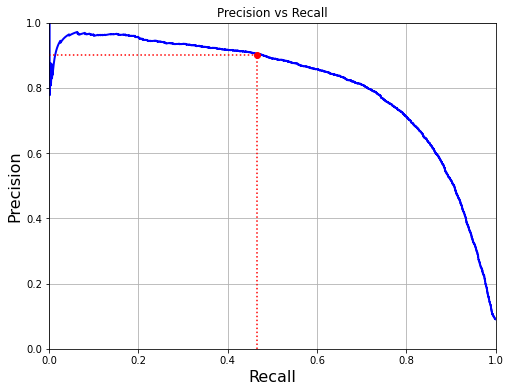

In [26]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.465, 0.465], [0, 0.9], "r:")
plt.plot([0.0, 0.465], [0.9, 0.9], "r:")
plt.plot([0.465], [0.9], "ro")
plt.title("Precision vs Recall")
plt.show();

**The precision recall starts to fall sharply around 80%. You will probably want to select a precision/recall trade-off just before the drop, like 60%. But of course the choise depends on the project.**

**Suppose you decide to aim for a 90% precision.You look up the first plot and find that you need to use a threshold of about 4000.**

**<font color='salmon'>To be more precise you can search for the lowest threshold the gives at least 90% precision with <font color='blue'>np.argmax()</font>, will give you the first index of the maximum value, which in this case means the first TRUE value.</font>**

In [27]:
# Find index of the first maximum value
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [28]:
'''
To make predictions (on the training set for now), instead of calling the classifier's predict() method,
run this code
'''
y_train_pred_90 = (y_scores >= threshold_90_precision)

# Check these predictions precision and recall
print("Precision: ", precision_score(y_train_5, y_train_pred_90))
print("Recall: ", recall_score(y_train_5, y_train_pred_90))

print("We get a 90% precision classifier.")
print("But high-precision is not very useful if its recal is too low.")

Precision:  0.9000345901072293
Recall:  0.4799852425751706
We get a 90% precision classifier.
But high-precision is not very useful if its recal is too low.


**<font color='salmon'>If someone says,  "Let's reach 99% precision,"  you should ask, "At what recall?"</font>.**

### ROC Curve (receiver operating characteristic)
ROC curve is another common tool used with binary classifiers.

**It is very similar to precision/recall , but instead of ploting precision versus recall, ROC curve plots <font color='salmon'>true positive rate</font> (another name for recall) against the <font color='salmon'>false positive rate</font> (FPR).**

**<font color='salmon'>FPR</font>: the ration of negative instances that are incorrectly classified as positive. It is equal to 1 - the true negative rate(TNR) which is the ration of negative instances that are correctly classified as negative.**

The (TNR) is also called <font color='salmon'>specificity</font>

**ROC curve plots <font color='salmon'>sencitivity</font> (recall) versus <font color='salmon'>1 - specificity</font>.**

**To plot the ROC curve, first use the <font color='blue'>roc_curve()</font> function to compute TPR and FPR for various threshold values.**

In [29]:
from sklearn.metrics import roc_curve
np.random.seed(42)

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , ..., 0.99937705, 0.99937705,
        1.        ]),
 array([0.00000000e+00, 1.84467810e-04, 9.22339052e-04, ...,
        9.99815532e-01, 1.00000000e+00, 1.00000000e+00]),
 array([  49442.43765905,   49441.43765905,   36801.60697028, ...,
        -105763.22240074, -106527.45300471, -146348.56726174]))

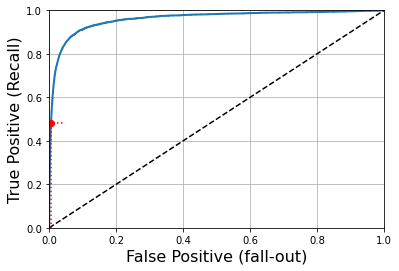

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")    # add dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive (fall-out)", fontsize=16)
    plt.ylabel("True Positive (Recall)", fontsize=16)
    plt.grid(True)
    
    
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0, 0.479985], "r:")
plt.plot([0, 4.837e-2], [0.479985, 0.479985], "r:")
plt.plot([4.837e-3], [0.479985], "ro")
plt.show();

**One way to compare classifiers is to measure the <font color='salmon'>area under the curve (AUC)</font>.**

A perfect classifier will have ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

**Scikit-Learn provides <font color='blue'>roc_auc_score()</font> function to compute the ROC AUC.**

In [31]:
from sklearn.metrics import roc_auc_score
np.random.seed(42)

'''
Reminder what is y_scores:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")    # set the method to return decision score
'''

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

#### <font color='salmon'>How to decide whitch one to use:</font>
* **You should prefer <font color='blue'>precision/recall (PR)</font> curve whenever the positive class is rare or you care more about the false positive than the false negative.**
* **Otherwise use <font color='blue'>ROC</font> curve.**

For example:
* Looking at the previous ROC curve (and the ROC AUC score) you may think that the classifier is really good. But this is mostly beacuse there are few positive (5s) compared to the negative (non-5s). in contrast. PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top left cornes).

### Try RandomForestClassifier
**<font color='red'>Compare ROC curve and the ROC AUC score to those of the SGDClassifier</font>.**

**First we need to get the scores for each instance in the training set.**

**<font color='blue'>RandomForestClissifier</font> doesn't have a <font color='blue'>decision_function()</font> mathod. Insted, it has a <font color='blue'>predict_proba()</font> method.**

Scikit_learn classifiers generally have one or the other.

**The <font color='blue'>predict_proba()</font> method returns an array containing a row per instance and a column per class, each conatining the probability that the given instance belongs to the given class (e.g. 70% chance that the image represents a 5).**

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probs_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                   method="predict_proba")  #!!!!
y_probs_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

**The <font color='blue'>roc_curve()</font> function expects labels and scores. Instead of scores you can give it class probabilities (use positive class's probability as score).**

In [33]:
y_scores_forest = y_probs_forest[:, 1]
y_scores_forest

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

In [34]:
fpr_forest, tpr_forest, threshold_fores = roc_curve(y_train_5, y_scores_forest)

In [35]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

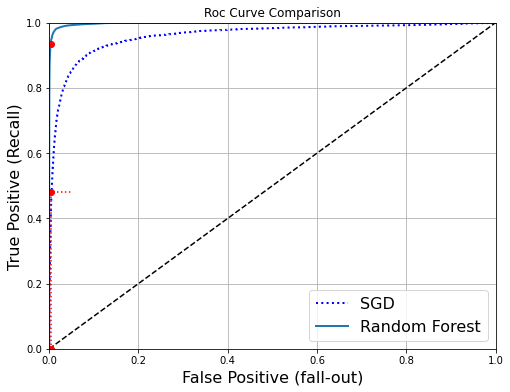

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0, 0.479985], "r:")
plt.plot([0, 4.837e-2], [0.479985, 0.479985], "r:")
plt.plot([4.837e-3], [0.479985], "ro")
plt.plot([4.837e-3, 4.837e-3], [0, 0.935], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.title("Roc Curve Comparison")
plt.show();

**The <font color='blue'>RandomForestClassifier</font>'s ROC curve looks much better than the <font color='blue'>SGDClassifier</font>'s, it's ROC AUC score is significantly better.**



### Compare precision/recall

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [38]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [39]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## Multiclass Classification
Multiclass Classifieres (also called Multinominal Classifiers) can distinguish between more than two classes.

**Some algorithms are capable of handling multiple classes nativity, such as:**
* **<font color='blue'>SGD classifiers</font>**
* **<font color='blue'>Random Forest classifiers</font>**
* **<font color='blue'>Naive Bayes classifiers</font>**

**Others are strictly binary classifers, such as:**
* **<font color='blue'>Logistic Regression</font>**
* **<font color='blue'>Suport Vector Machine classifiers</font>**

### <font color='salmon'>One-Versus-The-Rest (OvR)</font>
**Train 10 binary classifiers, one for each digit (0-detector, 1-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and select the class whose calssifier outputs the highest score.**

### <font color='salmon'>One-Versus-One (OvO)</font>
**Train a binary classifer for every pair of digits (0 and 1s, 0 and 2, and so on). If there are** <font color='red'>N</font>
 **classes you need to train** <font color='red'>N x (N - 1) / 2</font>
 N x (N - 1) / 2 **classifiers. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes it must distinguish.**
 
<font color='purple'>Some algorithms (such as Suport Vector Machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred beacuse it is faster to train many classifiers on small training sets than train a few classifiers on large training sets.</font>

<font color='purple'>For most binary classifications algorithms OvR is preferred.</font>

**Sciki-Learn detects when you try to use a binary classification algorithm for multiclass classification task, and automatically runs OvR or OvO, depending on the algorithm.**

### Suport Vector Machine Classifier
<font color='red'>Under the hood it uses OvO strategy: it trained 45 binary classifiers, gets their decision scores, and selects the calss that won the most duels.</font>

In [40]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])  # not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

**This code trains the <font color='salmon'>SVC</font> on the training set using the original target classes from 0 to 9 (y_train). Then it makes a prediction.**

**If you call the <font color='blue'>decision_function()</font> method, you will see 10 scores per instance. That's 1 score per class.**

In [41]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [42]:
# The index of each class matches the class itself (e.g. 1 is 7.09167958, and so on)
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

**If you want to forcce Scikit-Learn to use <font color='salmon'>OvO</font> or <font color='salmon'>OvR</font>, you can use the <font color='blue'>OneVsOneClassifier</font> or <font color='blue'>OneVsRestClassifier</font> classes.**

**Create an instance and pass a classifier to its constructor.**

In [43]:
from sklearn.multiclass import OneVsRestClassifier
np.random.seed(42)

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
len(ovr_clf.estimators_)

10

**SDGClassifier or RandomForestClassifier can directly classify instances into multiple classes.**

Ex. with SGDClassifier

In [45]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [46]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [47]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [48]:
# Scale X_train to get a better result
from sklearn.preprocessing import StandardScaler
np.random.seed(42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

**Simply scaling the imput increases the accuracy above.**

## Error Analysis
**Assume that we have found a promising model and want to find ways to improve it.**

**<font color='salmon'>One way is to do this is to analyze the typer of errors it makes.</font>**

**First look at the confusion matrix. We need to make predictions using <font color='blue'>cross_val_predict()</font> then call the<font color='blue'>confusion matrix</font> function.**

In [49]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

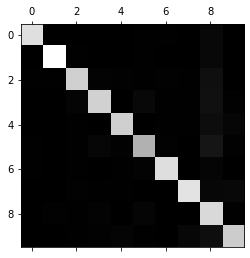

In [50]:
# Look at the confusion matrix using Matplotlib's "matshow()"
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show();

**The 5s look slightly darker, which could mean that there are fewer images of 5s or the the classifier doesn't perform well on 5s.**

**Focus the plot on the errors:**
    
Devide each value in the confusion matrix by the number of images in the corresponding class so that we can compare error rates.

In [51]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Fill the diagonal with zeros to keep only the errors

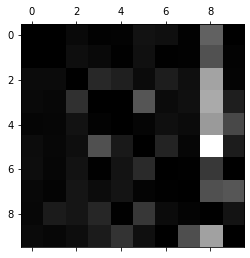

In [52]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show();

**<font color='salmon'>Rows represent classes, columns represent predicted classes.</font>**

**The column for class 8 is quite bright, which tells us that many images get misclassified as 8s. Also 3s and 5s often get confused.**

**Looking at this plot, it seems the efforts should be spent on reducing the false 8s:**
* **We could try to gather more training data for digits that look llike 8s so that the classifier can to distinguish them better from real 8s.**
* **We could engineer new features thet would help the classifier: riting an algorithm  to count the number of closed loops (e.g. 8 has tow, 6 has one, 5 has none).**
* **We could preprocess the images (using Sciki-Image, Pillow or OpenCV) to make some patterns stand out more.**

**Analyzing individual errors can also be a good way to gain insights on what your classifer is doing and why it is failing, but it is more difficult and time-consuming.**

For example :

----->First column shows digits classified as 3s
----->Secound column shows digits classifed as 5s


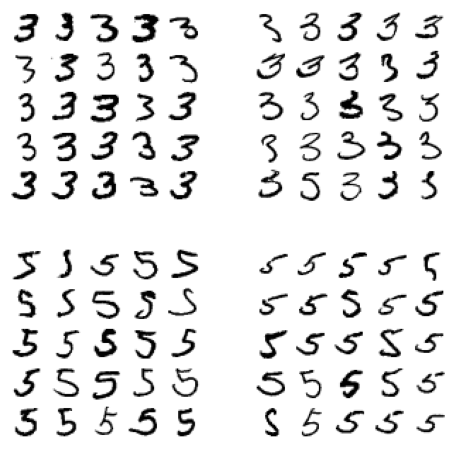

In [53]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
print("----->First column shows digits classified as 3s")
print("----->Secound column shows digits classifed as 5s")
plt.show();

**Some of the digits that the classifier gets wrong (bottom-left and top-right blocks) are so badly written that even a human would have trouble classifing them.**

**<font color='salmon'>However, most misclassified images seem like obvious errors.</font>**

**The reason is that we used a simple 
, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class (since 3s and 5s differ only by a few pixels, this model will easily confuse them).**

The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc.

**In other words, the classifier is quite sensitive to image shifting and rotation.**

**One way to reduce the 3 and 5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated.**

## Multilabel Classification
**In some cases we may want our classifer to output multiple classes for each instance.**

Consider face recognition classifier:  what should it do is it recognizes several people in the same picture?
I should attach one tag per person in recognizes.

Say the classifiers has been trinined to recognize three face Alice, Bob, and Charlie. Then when a recognizer is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning "Alice-yes, Bob-no, Chalie-yes"). 

**Such a classification syspem that outputs multiple binary tags is called a <font color='salmon'>multilabel classification</font> system.**

**Just for illustration purposes:**

In [55]:
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(42)

y_train_large = (y_train >= 7)   # digits smaller than 7
y_train_odd = (y_train % 2 == 1)   # odd digits

y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf =  KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [57]:
# some_digit = 5
knn_clf.predict([some_digit])

array([[False,  True]])

**The digit is smaller than 7 and odd.**

**Evaluate the Multilabel Classifier (measure the  <font color='blue'>f1_score</font>):**

In [58]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

**This assumes that all labels  are equally important.**

**If we want to give more weight to a classifier's score, one simple option os to give each label a weight equal to its <font color='salmon'>support</font>.**

**To do this, set <font color='blue'>avarage="weighted"</font>:**

In [59]:
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

## Multioutput Classification
**<font color='salmon'>It is generalization of multilabel classification where each label can be multiclass (it can have more than two possible values).</font>**

**To illustrate this, let's build a system that removes noise from images. It will take as input a noisy digit image, and it will output a clean digit image, represented as an array of pixel intesities, just like the MINIST images. Notice that the classifier's output is multilabel (one label per pixel) and each  label can have multiple values(pixels ontensity ranges from 0 to 25), <font color='salmon'>It is thus an example of a multioutput classification system</font>.**

Let's start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities with NumPy's <font color='blue'>rendint()</font> function.

The target image will be the original image.

In [68]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

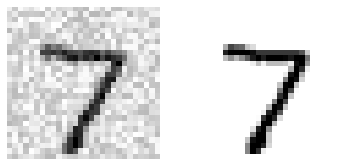

One the left noisy, on the right clean


In [74]:
# Take a look at a digit
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

plt.show();
print("One the left noisy, on the right clean")

**Train a classifire and make it clean the image.**

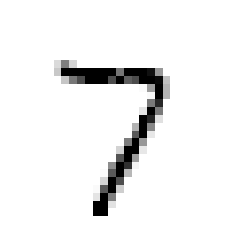

In [75]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)